# Teched 2022 - DA180 Session - Exercise 5

## Multi Model ML Scenario
### Problem statement
Create a machine learning model to forecast the fuel prices for the service stations in the Rhein-Neckar district based on 
the tanker König dataset.
### Dataset
The dataset is published on the public website “Tankerkönig“ (http://www.tankerkoenig.de/). This dataset contains the gas prices of all gas stations in Germany from 2014 until today as csv files. A record contains the station id, the datetime, prices for diesel, e5 and e10 and a change indicator. In a separate csv the data of the service stations including its geolocation is provided. 

We use the stations and prices data within this website only for blog posting and demonstration
purpose. For non-commercial use the data is availble with the following license agreement (https://creativecommons.org/licenses/by-nc-sa/4.0/)
Data download from https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data?path=/prices/2022

## Setup and connection

### Import the requied python packages

In [352]:
import hana_ml
print(hana_ml.__version__)
from hana_ml import dataframe
from hana_ml.dataframe import create_dataframe_from_pandas, create_dataframe_from_shapefile
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast
from hana_ml.algorithms.pal import metrics
from hdbcli import dbapi
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes



2.14.22091801


In [359]:
#pip freeze
#requirements txt
#pip install damit

### Connect to hana database

In [ ]:
host = '[YourHostName]'
port = 443
user = '[YourUser]'
passwd = '[YourUserPassword]'

In [3]:
#conn = dataframe.ConnectionContext(url, port, user, pwd)
conn= dataframe.ConnectionContext(address=host, port=port, user=user, password=passwd,
                               encrypt='true' ,sslValidateCertificate='false')

In [353]:
#conn = dataframe.ConnectionContext( address="<machine>", port=<SQL-port>,  user="<HANA-user>", password="<password>")
hc_url = '859c0f95-60f9-4540-aa81-581a8e452c6f.hna1.canary-eu10.hanacloud.ondemand.com'
conn = dataframe.ConnectionContext( address=hc_url, port=443, user="TECHED_USER_999", password='TechEd22Welcome' )
conn.hana_version()

'4.00.000.00.1663064250 (fa/CE2022.30)'

# EX1 Data preparation, Load datasets

Clone data from https://github.com/SAP-samples/teched2022-DA180/tree/main/data/fuelprice

In [3]:
#!dir fuelprice
!dir datasets

 Volume in drive C is OSDisk
 Volume Serial Number is 72BC-6B0D

 Directory of C:\Users\D059078\OneDrive - SAP SE\Documents\D059078_Docs\_Projekte\python\PythonNotebooks\##events\#22TE\FuelPriceForecast\datasets

02.10.2022  09:39    <DIR>          .
02.10.2022  09:39    <DIR>          ..
14.09.2022  16:33         3,720,892 AX_Gebiet_Kreis.shp
02.10.2022  09:39    <DIR>          georef-germany-kreis
05.10.2022  11:21           818,730 georef-germany-kreis-millesime.dbf
05.10.2022  11:21         6,810,700 georef-germany-kreis-millesime.shp
02.10.2022  09:32         5,542,990 georef-germany-kreis.zip
22.09.2022  10:18    <DIR>          OD_AX_Gebiet_Kreis
14.09.2022  16:33         1,896,433 stations.csv
14.09.2022  16:33         1,242,543 test_groundtruth.csv
14.09.2022  16:33         1,206,725 test_rnk.csv
14.09.2022  16:33        25,064,170 train_rnk.csv
               8 File(s)     46,303,183 bytes
               4 Dir(s)  449,718,611,968 bytes free


## Ex 1.2 Load station data csv file and create HANA db table

In [248]:
# load gas station data from csv
stations_pd = pd.read_csv('./datasets/stations.csv', sep=',', header=None, skiprows=1,
                          names=["uuid","name", "brand", "street","house_number",
                                  "post_code", "city", "latitude", "longitude"])

In [249]:
# create hana dataframe/DB table from pandas dataframe
stations_hdf = create_dataframe_from_pandas(
        conn,
        stations_pd,
        schema='TECHED_USER_999',
        table_name="GAS_STATIONS",
        force=True,
        replace=True,
        drop_exist_tab=False,
        geo_cols=[("longitude", "latitude")], srid=4326
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


In [250]:
print("There are", stations_hdf.count(), "service stations in Germany")

There are 15442 service stations in Germany


In [23]:
stations_hdf.head(2).collect()

,uuid,name,brand,street,house_number,post_code,city,latitude,longitude,longitude_latitude_GEO
0,00060723-0001-4444-8888-acdc00000001,BAGeno Raiffeisen eG,None,Künzelsauer Strasse,7,74653,Ingelfingen,49.296822,9.661385,POINT (9.661384582519501 49.296821594238)
1,005056ba-7cb6-1ed2-bceb-5332ab168d12,famila Tankstelle,FAMILA,Pascalstrasse,9,25442,Quickborn,53.742150,9.941240,POINT (9.941239999999999 53.74215)


## Ex 1.3 Regional boundary Shapefile and create HANA db table

In [12]:
# create dataframe from shapefile for german regions "Landreise"
regions_hdf = create_dataframe_from_shapefile(
  connection_context=conn,
  shp_file='./datasets/georef-germany-kreis.zip',
  srid=25832,
  schema='TECHED_USER_999',
  table_name="GEO_GERMANY_REGIONS")

In [28]:
regions_hdf.head(2).collect()

,year,lan_code,lan_name,krs_code,krs_name,krs_area_co,krs_type,krs_name_sh,SHAPE
0,2021,03,Niedersachsen,03460,Landkreis Vechta,DEU,Landkreis,Vechta,"POLYGON ((8.459274000000001 52.801056, 8.4603 ..."
1,2021,09,Bayern,09671,Landkreis Aschaffenburg,DEU,Landkreis,Aschaffenburg,"POLYGON ((9.40498 50.08774, 9.402760000000001 ..."


In [30]:
regions_hdf.filter("\"lan_name\"='Baden-Württemberg'").head(10).collect()

,year,lan_code,lan_name,krs_code,krs_name,krs_area_co,krs_type,krs_name_sh,SHAPE
0,2021,08,Baden-Württemberg,08315,Landkreis Breisgau-Hochschwarzwald,DEU,Landkreis,Breisgau-Hochschwarzwald,"POLYGON ((8.136039999999999 48.00932, 8.13449 ..."
1,2021,08,Baden-Württemberg,08415,Landkreis Reutlingen,DEU,Landkreis,Reutlingen,"(POLYGON ((9.582470000000001 48.53915, 9.57895..."
2,2021,08,Baden-Württemberg,08115,Landkreis Böblingen,DEU,Landkreis,Böblingen,"POLYGON ((8.928800000000001 48.866554, 8.92909..."
3,2021,08,Baden-Württemberg,08125,Landkreis Heilbronn,DEU,Landkreis,Heilbronn,"POLYGON ((9.049125999999999 49.29286, 9.04133 ..."
4,2021,08,Baden-Württemberg,08421,Stadtkreis Ulm,DEU,Stadtkreis,Ulm,"POLYGON ((10.03269 48.4572, 10.03069 48.45753,..."
5,2021,08,Baden-Württemberg,08337,Landkreis Waldshut,DEU,Landkreis,Waldshut,"POLYGON ((8.439030000000001 47.85364, 8.438359..."
6,2021,08,Baden-Württemberg,08216,Landkreis Rastatt,DEU,Landkreis,Rastatt,"(POLYGON ((8.232635 48.96657, 8.22793000000000..."
7,2021,08,Baden-Württemberg,08119,Landkreis Rems-Murr-Kreis,DEU,Landkreis,Landkreis Rems-Murr-Kreis,"POLYGON ((9.41624 49.04738, 9.4124 49.04457, 9..."
8,2021,08,Baden-Württemberg,08327,Landkreis Tuttlingen,DEU,Landkreis,Tuttlingen,"POLYGON ((8.640143999999999 47.85481, 8.644909..."
9,2021,08,Baden-Württemberg,08212,Stadtkreis Karlsruhe,DEU,Stadtkreis,Karlsruhe,"POLYGON ((8.27735 48.98994, 8.278335999999999 ..."


## Ex 1.4 Identify Gas stations in local regions close to SAP Headquarter

In [24]:
# filter service stations in Germany to those regions the close to SAP Headquarters "Rhein-Neckar-Kreis". Mannheim and Heidelberg 
stations_rnk_hdf = stations_hdf.join(regions_hdf, 
       '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis' or \"krs_name\"='Stadtkreis Heidelberg' or \"krs_name\"='Stadtkreis Mannheim'")

In [25]:
print(stations_rnk_hdf.select_statement)

SELECT * FROM (SELECT * FROM (SELECT "uuid", "name", "brand", "street", "house_number", "post_code", "city", "latitude", "longitude", "longitude_latitude_GEO" FROM (SELECT * FROM "TECHED_USER_999"."GAS_STATIONS") dt) AS "DT_10" INNER JOIN (SELECT * FROM "TECHED_USER_999"."GEO_GERMANY_REGIONS") AS "DT_4" ON "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1) AS "DT_12" WHERE "krs_name"='Landkreis Rhein-Neckar-Kreis' or "krs_name"='Stadtkreis Heidelberg' or "krs_name"='Stadtkreis Mannheim'


In [26]:
# number of service stations in Rhein-Neckar-Kreis
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count())

Number of Serice Stations in the Rhein-Neckar area 171


## Ex 1.5 Visualize station on map (optional)

In [27]:
# optional -- needed only for visualization
# filter service stations in Germany to those NOT within the polygon of "Rhein-Neckar-Kreis" 
stations_bw_hdf = stations_hdf.join(regions_hdf, '"longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1').filter("\"krs_name\"!='Landkreis Rhein-Neckar-Kreis' AND \"krs_name\"!='Stadtkreis Heidelberg' AND \"krs_name\"!='Stadtkreis Mannheim'")

In [28]:
# number of service stations in Germany, excluding the ones selected around the SAP Headquarters and area
print("Number of Service Stations in Baden-Württemberg, excluding Rhein-Neckar area",stations_bw_hdf.count())

Number of Service Stations in Baden-Württemberg, excluding Rhein-Neckar area 15263


In [29]:
# Collecting the HANA dataframe spatial data for visualization into geopandas dataframe
stations_rnk_pd = stations_rnk_hdf.collect()
stations_rnk_geopands = gpd.GeoDataFrame(
    stations_rnk_pd, geometry=gpd.points_from_xy(stations_rnk_pd.longitude, stations_rnk_pd.latitude))

stations_bw_pd = stations_bw_hdf.collect()
stations_bw_geopands = gpd.GeoDataFrame(
    stations_bw_pd, geometry=gpd.points_from_xy(stations_bw_pd.longitude, stations_bw_pd.latitude))

In [ ]:
# read shape-file into geopandas
# wtf
#!SET GDAL_DATA=C:\ProgramFiles\OSGeo4W\apps\gdal\share\gdal
#!pip install osgeo
#from osgeo import gdal
#import gdal
#import fiona
#fiona.__version__
#fiona.supported_drivers
# de = gpd.read_file('./datasets/georef-germany-kreis/georef-germany-kreis-millesime.shp')

In [13]:
regions_pd = regions_hdf.collect()
regions_geopands = gpd.GeoDataFrame(regions_pd, geometry='SHAPE')
#print(regions_geopands.crs)
#regions_geopands = regions_geopands.to_crs({'init': 'epsg:4326'})

In [16]:
import pyproj
pyproj.crs = {'init' :'epsg:4326'}
#my_geoseries.crs = {'init' :'epsg:4326'}
#bw_4326 = regions_geopands.to_crs({'init': 'epsg:4326'})

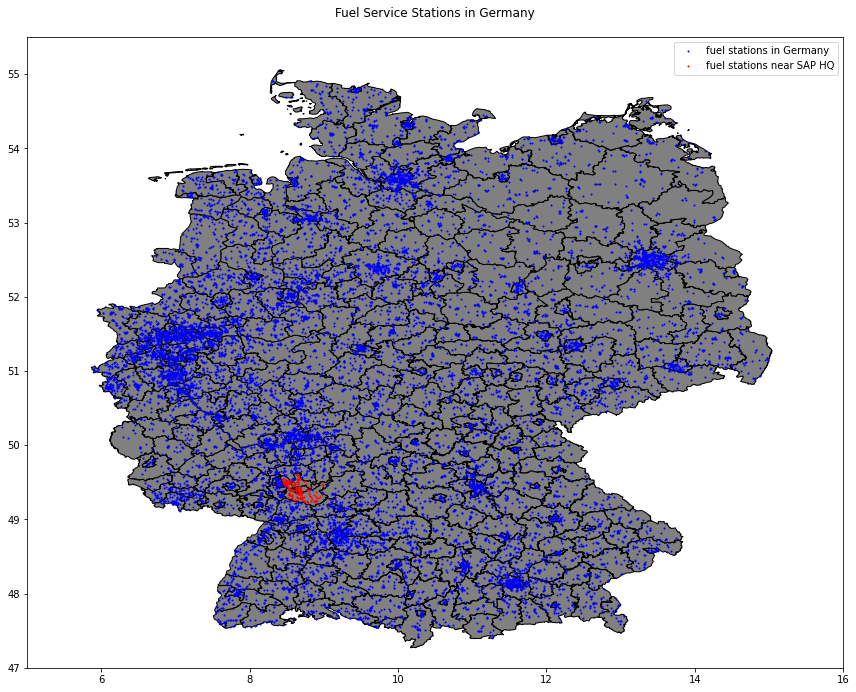

In [38]:
#plotshp = regions_geopands.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
fig, ax = plt.subplots(figsize=(12,12))
ax.set_xlim((5,16))
ax.set_ylim((47,55.5))
#ax.set_xlim((8.2,9.2))
#ax.set_ylim((49,50))

regions_geopands.plot(ax=ax, facecolor='Grey', edgecolor='k')
stations_bw_geopands.plot(ax=ax, marker='.',  color='blue', markersize=4, label='fuel stations in Germany ')
stations_rnk_geopands.plot(ax=ax, marker='.',  color='red', markersize=4, label='fuel stations near SAP HQ')

ax.legend()
ax.set_title('Fuel Service Stations in Germany', pad=20)
fig = ax.get_figure()
fig.tight_layout()

#  Ex2 Analysis of the gas price dataset and creation of train and test datasets

Prerequisite: the fuel price records for the currenty year is loaded into a HANA DB table. Due to the size of the dataset, this is not inclued in the git repo. We only provide the resulting datasets for training, testing and the corresponding ground truth. Those dataset are small enough to be included in the git repository.


## Ex 2.1 Load Fuel price / "Tankerkönig" csv file and create HANA db table

In [21]:
# retrive hana dataframes from CSV files
gasprices_tmp_pd = pd.read_csv('./data/06/06/2022-06-30-prices.csv', sep=',', header=0, skiprows=1,
                                      names=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"],
                                      usecols=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"])

# create hana dataframe from stadions pandas dataframe
gasprices_tmp_hdf = create_dataframe_from_pandas(
        conn,
        gasprices_tmp_pd,
        schema='TECHED_USER_999',
        table_name="GAS_PRICES_STAGING",
        append=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.82s/it]


In [488]:
mypath='./data/09/09'
from os import listdir
from os.path import isfile, join
pricefiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
pricefiles

['2022-09-01-prices.csv',
 '2022-09-02-prices.csv',
 '2022-09-03-prices.csv',
 '2022-09-04-prices.csv',
 '2022-09-05-prices.csv',
 '2022-09-06-prices.csv',
 '2022-09-07-prices.csv',
 '2022-09-08-prices.csv',
 '2022-09-09-prices.csv',
 '2022-09-10-prices.csv',
 '2022-09-11-prices.csv',
 '2022-09-12-prices.csv',
 '2022-09-13-prices.csv',
 '2022-09-14-prices.csv',
 '2022-09-15-prices.csv',
 '2022-09-16-prices.csv',
 '2022-09-17-prices.csv',
 '2022-09-18-prices.csv',
 '2022-09-19-prices.csv',
 '2022-09-20-prices.csv',
 '2022-09-21-prices.csv',
 '2022-09-22-prices.csv',
 '2022-09-23-prices.csv',
 '2022-09-24-prices.csv',
 '2022-09-25-prices.csv',
 '2022-09-26-prices.csv',
 '2022-09-27-prices.csv',
 '2022-09-28-prices.csv',
 '2022-09-29-prices.csv',
 '2022-09-30-prices.csv']

In [477]:
#pricefiles=['2022-07-01-prices.csv', '2022-07-02-prices.csv']

In [489]:
gps=conn.table('GAS_PRICES_STAGING')
gps.count()

0

In [490]:
gp_tmp_pd = {}
for file in pricefiles:
    gp_tmp_pd[file] = pd.read_csv('./data/09/09/{}'.format(file), sep=',', header=0, skiprows=1,
                                      names=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"],
                                      usecols=["date", "station_uuid", "diesel", "e5", "e10", "dieselchange", "e5change", "e10change"])
    gasprices_tmp_hdf = create_dataframe_from_pandas(
        conn, gp_tmp_pd[file],
        schema='TECHED_USER_999', table_name="GAS_PRICES_STAGING",
        append=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.71s/it]


In [492]:
gps.count()

0

In [ ]:
#--loaded until end of June
#INSERT INTO RAW_DATA.GAS_PRICES SELECT * FROM TECHED_USER_999.GAS_PRICES_STAGING;

## Ex 2.2 Analysis of fuel price data

In [125]:
# create hana dataframe including all gas prices in Germany in 2022
fuelprice_all_hdf = conn.sql('select * from "RAW_DATA"."GAS_PRICES"')

In [126]:
print("There are", fuelprice_all_hdf.count(), "records in the dataset")

There are 59534927 records in the dataset


In [127]:
fuelprice_all_hdf.sort('date', desc=True).head(3).collect()

,date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change
0,2022-06-30 23:59:08,1674639b-579b-49ea-8e6b-7ad8d75c38e0,1.959,1.869,1.829,1,1,1
1,2022-06-30 23:59:08,a83c3cc3-9997-43db-ae23-8f604da06613,1.989,1.969,1.909,1,1,1
2,2022-06-30 23:58:08,86b326fe-dc4e-4075-95ff-a51cc02c0235,2.089,1.989,1.929,1,1,1


In [128]:
# Selecting columns in focus
fuelprice_all_hdf=fuelprice_all_hdf.select('date', 'station_uuid', 'e5')
fuelprice_all_hdf.head(6).collect()

,date,station_uuid,e5
0,2022-04-05 20:23:08,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
1,2022-04-08 06:04:09,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
2,2022-04-15 10:54:09,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
3,2022-04-18 06:01:09,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
4,2022-04-19 20:17:14,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
5,2022-04-19 21:19:16,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999


In [83]:
# Count the price changes per fuel service station
fuelprice_all_hdf.agg([('count', 'date', 'N')], group_by='station_uuid').collect()

,station_uuid,N
0,436782d2-cf94-408c-9715-693f0be4b091,3770
1,a1ea6437-ddbc-4f1c-a5bb-2b5fa33f8e7e,4571
2,a19a5477-304e-4a99-adc5-3b2282c11297,1817
3,3aeed500-8dda-4bd8-be55-d13e415e81b1,4217
4,7221415e-d627-40c6-be7f-285cf6744492,7635
...,...,...
15189,722ed42d-2e89-4f62-91aa-e3e1c32bfeab,4820
15190,fe5d93c8-bf5f-4ef6-9d4b-42ab6f14e3a0,3695
15191,fb9007ec-61a6-48a3-a09c-bfd8ef887d15,4925
15192,51d4b539-a095-1aa0-e100-80009459e03a,3143


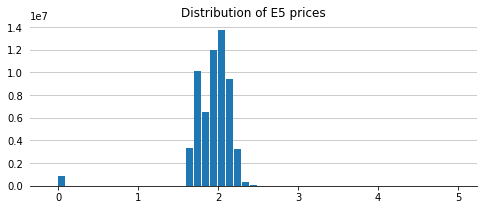

In [84]:
# Show e5 value distribution to identify outlier data ranges

# Distribution Histogram (incl. binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=50, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

In [129]:
# Filter outliers
fuelprice_all_hdf=fuelprice_all_hdf.filter('"e5" > 1.3 and "e5"< 2.8')

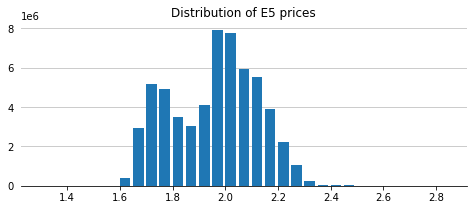

In [88]:
# Distribution Histogram (incl. binnning)
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure(figsize=(8,3))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, dist_data = eda.distribution_plot( data=fuelprice_all_hdf, column="e5", bins=30, 
                                      title="Distribution of E5 prices", debrief=False)
plt.show()

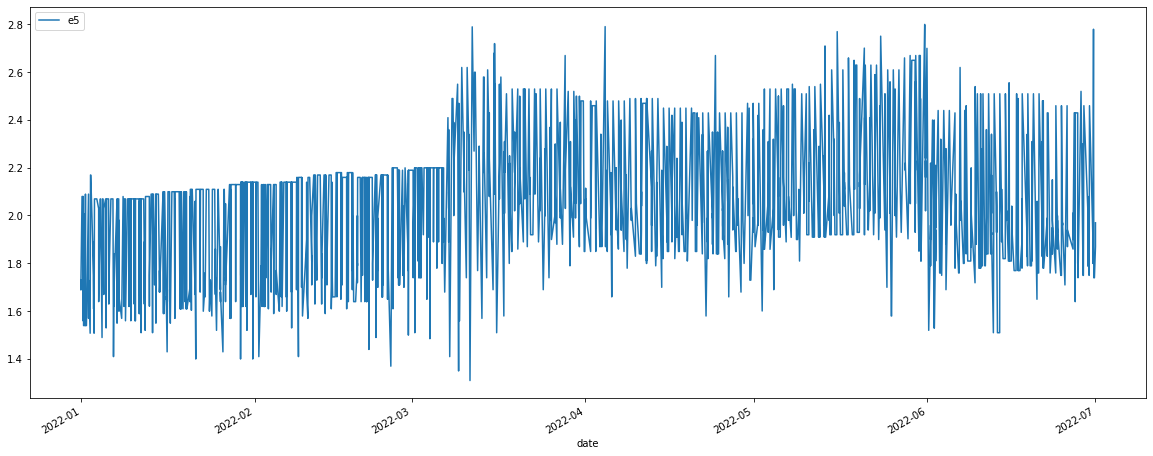

In [87]:
%matplotlib inline
from hana_ml.visualizers.m4_sampling import m4_sampling
fuelprice_sample=m4_sampling(fuelprice_all_hdf.select('date', 'e5'), 200)
#fuelprice_sample.head(6).collect()

fuelprice_sample_pd=fuelprice_sample.collect()
fuelprice_sample_pd.set_index(fuelprice_sample_pd.columns[0], inplace=True)
fuelprice_sample_pd.sort_index(inplace=True)
fuelprice_sample_pd=fuelprice_sample_pd.astype(float)
#ax.set_ylim((1.3,2.8))
ax = fuelprice_sample_pd.plot(figsize=(20,8))

<AxesSubplot:>

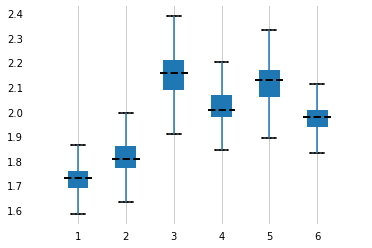

In [112]:
from hana_ml.visualizers.eda import timeseries_box_plot
timeseries_box_plot(data=fuelprice_sample, col="e5", key="date", cycle="MONTH")

In [130]:
# Add day and HOUR for better analysis
fuelprice_alldh_hdf=fuelprice_all_hdf.select('date',('EXTRACT(DAY FROM "date")||\'-\'||EXTRACT(MONTH FROM "date")||\'-\'||EXTRACT(YEAR FROM "date")', 'DAY'),('HOUR("date")', 'HOUR'),'station_uuid', 'e5')
fuelprice_alldh_hdf.head(6).collect()
#filter("\"krs_name\"='Landkreis Rhein-Neckar-Kreis' or \"krs_name\"='Stadtkreis Heidelberg' or \"krs_name\"='Stadtkreis Mannheim'")

,date,DAY,HOUR,station_uuid,e5
0,2022-04-05 20:23:08,5-4-2022,20,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
1,2022-04-08 06:04:09,8-4-2022,6,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
2,2022-04-15 10:54:09,15-4-2022,10,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
3,2022-04-18 06:01:09,18-4-2022,6,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
4,2022-04-19 20:17:14,19-4-2022,20,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999
5,2022-04-19 21:19:16,19-4-2022,21,ab689d82-a00a-499d-aee8-1009d2fa7b74,1.999


In [131]:
fuelprice_focusdays_hdf=fuelprice_alldh_hdf.filter('"date" < \'2022-03-14 00:00:00.000\' and "date" > \'2022-03-05 00:00:00.000\'')
#fuelprice_focusdays_hdf.agg([('avg', 'e5', 'AVG_DAILY_E5')], group_by='DAY').sort('DAY').collect()

In [ ]:
#case wenn substring in 2-9 dann ersetze durch 0+value
#fuelprice_focusdays_hdf.

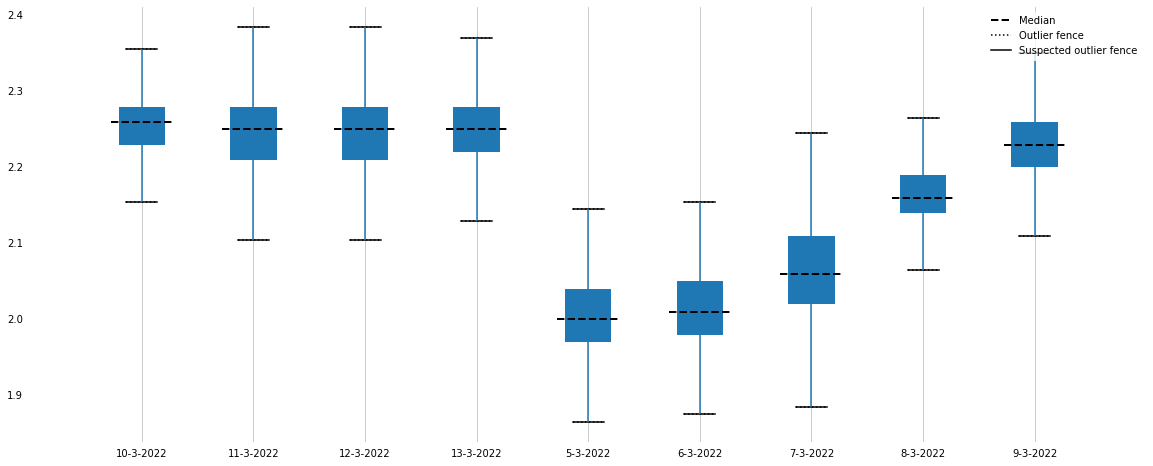

In [132]:
#case wenn substring in 2-9 dann ersetze durch 0+value
f = plt.figure(figsize=(20, 8))
ax1 = f.add_subplot(111)
eda = EDAVisualizer(ax1)
ax1, corr = eda.box_plot(data=fuelprice_focusdays_hdf.sort('DAY'), column="e5", groupby="DAY", vert=True)
plt.show()

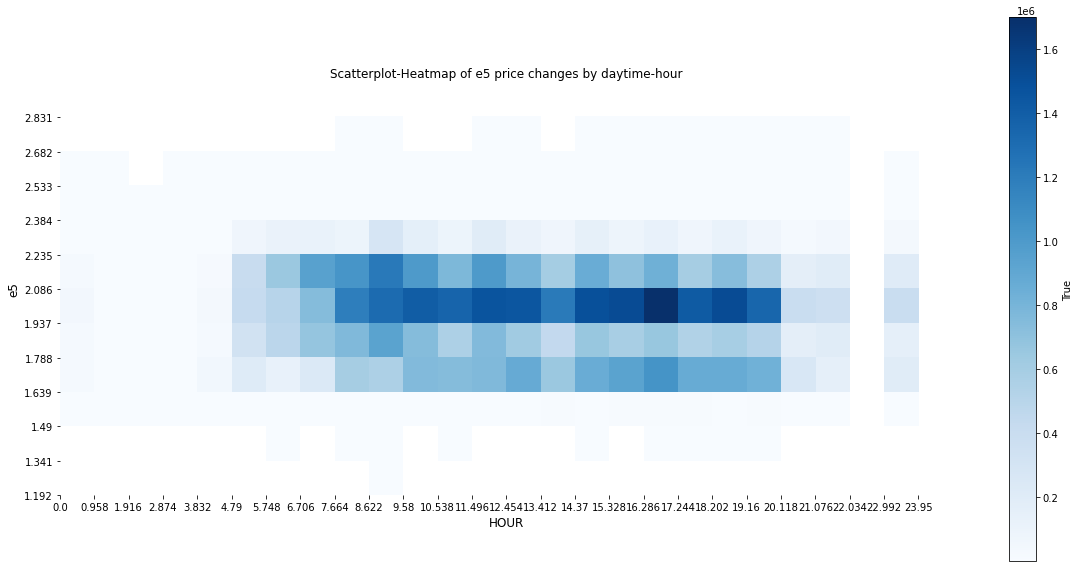

In [133]:
# vielleicht nur Tag-value
#fuelprice_focusdays_hdf

#price by daytime
#Scatterplot
#scatter_plot(self, data, x, y, x_bins, y_bins, title=None, label=True, cmap='Blues', debrief=True, rounding_precision=3)

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(111)

eda = EDAVisualizer(ax1)
ax, bin_matrix = eda.scatter_plot(data=fuelprice_alldh_hdf, x='HOUR', y='e5', x_bins=24,  y_bins=10,
                                  title="Scatterplot-Heatmap of e5 price changes by daytime-hour", 
                                  cmap="Blues", debrief=False, label=True)
plt.show()

In [ ]:
#daily pattern aggregiert
#what are typical daily patterns

# Forecast Model Training

## Ex 3.1 Selecting Price data for area RNK to Forecast price for local station

Demo

In [134]:
# number of service stations in Rhein-Neckar-Kreis
print("Number of Serice Stations in the Rhein-Neckar area", stations_rnk_hdf.count())

Number of Serice Stations in the Rhein-Neckar area 171


In [147]:
#stations_rnkids_hdf=stations_rnk_hdf.select('uuid')
#fuelprice_rnk_hdf = fuelprice_all_hdf.set_index("station_uuid").join(stations_rnkids_hdf.set_index("uuid"))
#print(fuelprice_rnk_hdf.select_statement)

In [150]:
fuelprice_rnk_hdf=conn.sql('select "date", "station_uuid", "e5" from "RAW_DATA"."GAS_PRICES" WHERE "station_uuid" IN (SELECT "uuid" FROM (SELECT * FROM "GAS_STATIONS") AS S, (SELECT * FROM "GEO_GERMANY_REGIONS" WHERE "krs_name"=\'Landkreis Rhein-Neckar-Kreis\' or "krs_name"=\'Stadtkreis Heidelberg\' or "krs_name"=\'Stadtkreis Mannheim\' ) AS G WHERE "longitude_latitude_GEO".ST_SRID(25832).st_transform(25832).st_intersects(SHAPE)=1)')

In [151]:
fuelprice_rnk_hdf.head(5).collect()

,date,station_uuid,e5
0,2022-06-05 23:22:06,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.999
1,2022-06-05 23:22:06,c1a08069-b2c6-462f-848e-8667620228b3,1.999
2,2022-06-05 23:22:06,e7072d33-0f89-4846-bd52-58f5bae07501,1.999
3,2022-06-05 23:23:09,c9f44d03-5ead-4337-9c41-5b2f253f3b7d,1.999
4,2022-06-06 23:22:09,0c7e5731-68c4-49f9-bcbc-87dbaa191294,1.999


In [152]:
# performs the join on the database (defined above)
print("The dataset for the fuel prices for the service stations in Rhein-Neckar area contains",
     fuelprice_rnk_hdf.count(), "records")

The dataset for the fuel prices for the service stations in Rhein-Neckar area contains 629604 records


In [153]:
print( "The dataset covers the time period starting from: ")
print( fuelprice_rnk_hdf.sort('date').select('date').head(1).collect(), "\n")
print( "... and ends at: ")
print( fuelprice_rnk_hdf.sort('date', desc=True).select('date').head(1).collect())

The dataset covers the time period starting from: 
                 date
0 2022-01-01 00:02:17 

... and ends at: 
                 date
0 2022-06-30 23:36:05


In [24]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-06-14
train_rnk_trunc_hdf  = train_rnk_hdf.filter('"date" < \'2022-06-23 00:00:00.000\'')

In [25]:
# ground truth
test_groundtruth_rnk_hdf  = train_rnk_hdf.filter('"date" >= \'2022-06-23 00:00:00.000\'')

In [26]:
# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

In [27]:
test_groundtruth_rnk_hdf.head(3).collect()

,date,station_uuid,e5
0,2022-06-17 09:31:07,e1e4230d-98d0-433b-ad28-bf673862592f,2.019
1,2022-06-18 07:01:08,66f17d7a-2572-4c7a-81a3-91da096629cd,2.029
2,2022-06-18 07:01:08,c0bc562d-d77f-440e-9182-57654145275c,2.009


 Load prepared csv files for Fuelprice Forecasting

In [154]:
# retrive hana dataframes from CSV files
train_rnk_pd = pd.read_csv('./datasets/train_rnk.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"])
# create hana dataframe from stadions pandas dataframe
train_rnk_hdf = create_dataframe_from_pandas(
        conn,
        train_rnk_pd,
    schema='TECHED_USER_999',
        table_name="TRAIN_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station": "NVARCHAR(50)", "e5": "DOUBLE"}
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.05it/s]


In [155]:
# retrive hana dataframes from CSV files
test_groundtruth_rnk_pd = pd.read_csv('./datasets/test_groundtruth.csv', sep=',', header=None, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"],)
# create hana dataframe from stadions pandas dataframe
test_gt_rnk_hdf = create_dataframe_from_pandas(
        conn,
        test_groundtruth_rnk_pd,
        schema='TECHED_USER_999',
        table_name="TEST_GT_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station_uuid": "NVARCHAR(50)", "e5": "DOUBLE"}  
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


In [156]:
# retrive hana dataframes from CSV files
test_rnk_pd = pd.read_csv('./datasets/test_rnk.csv', sep=',', header=0, skiprows=1,
                                      names=["idx", "date", "station_uuid", "e5"],
                                      usecols=["date", "station_uuid", "e5"])
# create hana dataframe from stadions pandas dataframe
test_rnk_hdf = create_dataframe_from_pandas(
        conn,
        test_rnk_pd,
        schema='TECHED_USER_999',
        table_name="TEST_RNK",
        force=True,
        replace=True,
        drop_exist_tab=True,
        table_structure={"date": "TIMESTAMP", "station_uuid": "NVARCHAR(50)", "e5": "DOUBLE"}  
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


In [157]:
print('Number of records', train_rnk_hdf.count())

Number of records 354578


## Ex 3 Model fuel price time series for each gas station 
### Ex3.1 Time series forecasting using Prophet (Additive Model Forecast)
Massive Mode Support available for ARIMA, Auto ARIMA, Additive Model Forecast, UnifiedClassification, UnifiedRegression.

In [403]:
from hana_ml.algorithms.pal.tsa.additive_model_forecast import AdditiveModelForecast

In [ ]:
conn.create_table(table='PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY',schema='TECHED_USER_999', table_structure={'GROUP_IDXXX': 'INTEGER', 'ts': 'TIMESTAMP', 'NAME': 'VARCHAR(255)', 'LOWER_WINDOW': 'INTEGER', 'UPPER_WINDOW': 'INTEGER'})

In [405]:
# create hoildays table, required but kept empty for now
holiday_data_hdf = conn.sql('select * from "TECHED_USER_999"."PAL_ADDITIVE_MODEL_ANALYSIS_HOLIDAY"')

In [406]:
amf = AdditiveModelForecast(massive=True,growth='linear',
                                changepoint_prior_scale=0.06,
                                weekly_seasonality='True',
                                daily_seasonality='True'
                                )

In [407]:
amf.fit(data=train_rnk_hdf, key="date", group_key="station_uuid", holiday=holiday_data_hdf)

In [409]:
amf.runtime

63.19862103462219

In [ ]:
#print(conn.last_execute_statement)
print(amf.get_fit_execute_statement())

In [410]:
pd.set_option('max_colwidth', None)
df=amf.model_.head(5).collect()

display(df.style.set_properties(**{'text-align': 'left'}))

,GROUP_ID,ROW_INDEX,MODEL_CONTENT
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 07:04:21.0000000"",""y_scale"":2.279,""t_scale"":14131673.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.11985001379979339,""m"":0.6842648140750764,""delta"":[[-0.0001340751775108697,-0.048402618988419947,-0.0007665043413144952,0.05108050894864811,0.03260231184748215,-0.005360524098684303,-0.05732560302089375,-0.06123043187024291,0.00003510353169544275,1.0376809131360712,1.305488655501079,0.2096891271971394,-3.3190567073490047,0.000189318605438322,0.31233977752298128,-0.11150967490707396,-0.0002880214837518904,0.00010942259771485436,0.7024105977788815,0.00009121714598477968,-0.0001489320068077082,-0.0001610143081463754,0.1657528162210715,0.4918075603571101,-1.1809878535876502]],""sigma_obs"":0.01897277488527507,""beta"":[[-0.008569782391440118,-0.108332779067458,-0.039530357100094729,-0.08620530354765214,-0.04503869564091142,-0.0353597825932281,-0.01917504956496624,-0.004199363901422187,0.0016268479422298379,-0.005626929794167598,-0.0012062710219292225,0.0008668042485764292,0.0013970029078147254,-0.00042991019718025816]],""changepoints_t"":[[0.030772577316217268,0.06373668567055012,0.09991102964242096,0.1307237295966302,0.16456551181165883,0.19653624875129789,0.22932217579617079,0.2636959544705004,0.2930003404409372,0.32424094443736425,0.35701837991864096,0.3888617434043372,0.42282806855210988,0.45526577072650917,0.48642987988754057,0.5199375898380892,0.5512207224155271,0.5813824024940288,0.6080374206224557,0.6387684600400816,0.6727346436617944,0.7044253005288192,0.7360817080893395,0.767347786776555,0.7979172741967635]],""holidays_prior_scale"":10.0}"
1,0e5f8257-c5e6-44f2-8d7f-4ba90f7b9646,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:06:11.0000000"",""y_scale"":2.349,""t_scale"":14155803.0,""cat_field_moments"":"""",""seasonality_name"":[[""daily"",""weekly""]],""seasonality_period"":[[1.0,7.0]],""seasonality_fourier_order"":[[4.0,3.0]],""seasonality_prior_scale"":[[10.0,10.0]],""seasonality_mode"":[[0,0]],""k"":0.005907669681544336,""m"":0.7290246832797076,""delta"":[[0.000011171619274320265,0.0002431516582376467,0.07282322372221743,0.05595639163079752,0.058292916409878697,-0.000003040847655086318,-0.010384318787307352,-0.05271610547383504,7.807203779698594e-8,0.925467112886796,1.3654437926349957,-0.8732588054138294,-3.1046824982804415,1.2236682080288513,0.000550898981119291,0.0000022283423552906018,-0.11421102708486546,0.5651604477132911,0.0013767695459064723,2.4955506881158286e-7,0.07620490360070398,0.005267195426158921,0.03660491824556767,0.8787075758860701,-1.4705862083652657]],""sigma_obs"":0.020618834157776296,""beta"":[[0.02194630076000771,-0.01859275902678812,-0.0008186204797354343,-0.016092777099060878,-0.0026063151982798,-0.006325423130673538,0.00023765672200227366,-0.0020975158898193025,-0.004155333635364348,0.0028831381931466199,0.0021027312269033596,-0.002503772159937363,0.00016124188300897972,0.0009575875063574003]],""changepoints_t"":[[0.03399291442527139,0.06423923814141805,0.09446839575261114,0.12591867801494553,0.16203503255873229,0.19340866780923697,0.22892802336963859,0.26370075932817096,0.29639265253973937,0.3278385549728263,0.36277730058831705,0.4011139459909127,0.43765062285763658,0.47287370416217297,0.5043102111551001,0.5346454736619322,0.5653495601768406,0.5999063422965126,0.6306485050689106,0.6633110110390771,0.6934892354746671,0.7225319538566621,0.7488232917623959,0.7789382206011203,0.8100195375705638]],""holidays_prior_scale"":10.0}"
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,0,"{""GROWTH"":""linear"",""FLOOR"":0.0,""SEASONALITY_MODE"":""additive"",""start"":""2022-01-01 00:02:17.0000000"",""y_scale""

In [411]:
# predict returns an array of three dataframes. The first contains the forecasted values
fc_result, fc_decomp, fc_error = amf.predict(data=test_rnk_hdf, key="date", group_key="station_uuid")

In [177]:
#print(amf.get_predict_execute_statement())

In [412]:
# look at forecast result data
fc_result.head(3).collect()

,GROUP_ID,date,YHAT,YHAT_LOWER,YHAT_UPPER
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:04:12,2.012191,1.957376,2.068663
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:14:10,2.030731,1.973301,2.084730
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 07:52:09,1.973850,1.919704,2.029074


In [413]:
fc_decomp.head(3).collect()

,GROUP_ID,date,TREND,SEASONAL,HOLIDAY,EXOGENOUS
0,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:04:12,1.800563,"{""seasonalities"":0.21162745993495489}",{},{}
1,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 05:14:10,1.800529,"{""seasonalities"":0.23020220514391188}",{},{}
2,0e64e4c6-3d58-44d4-bbe5-377a5a0db2f2,2022-06-14 07:52:09,1.799984,"{""seasonalities"":0.1738655605672593}",{},{}


In [414]:
# check for errors in any of the station_uuids
fc_error.head(3).collect()

,GROUP_ID,ERROR_TIMESTAMP,ERRORCODE,MESSAGE


### Ex 3.2 Evaluate Forecast Accuracy and plot forecast

In [415]:
# look at predictions for one service stations
fc_result.filter('"GROUP_ID" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\' or "GROUP_ID" = \'938c082c-e2c6-4292-8b2c-cdf83036e555\'').collect()

,GROUP_ID,date,YHAT,YHAT_LOWER,YHAT_UPPER
0,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,2022-06-14 05:01:07,2.027363,1.978737,2.076191
1,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,2022-06-14 07:48:09,1.999464,1.950387,2.047162
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,2022-06-14 08:30:10,1.982257,1.934160,2.033773
3,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,2022-06-14 08:43:09,1.977503,1.932115,2.025035
4,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,2022-06-14 09:01:09,1.971451,1.922042,2.017827
...,...,...,...,...,...
301,938c082c-e2c6-4292-8b2c-cdf83036e555,2022-06-21 18:38:08,1.876926,1.814858,1.930925
302,938c082c-e2c6-4292-8b2c-cdf83036e555,2022-06-21 18:52:09,1.875036,1.820688,1.937098
303,938c082c-e2c6-4292-8b2c-cdf83036e555,2022-06-21 20:09:09,1.870778,1.811936,1.930174
304,938c082c-e2c6-4292-8b2c-cdf83036e555,2022-06-21 20:38:08,1.873821,1.809735,1.928033


In [419]:
fc2g=fc_result.filter('"GROUP_ID" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\' or "GROUP_ID" = \'938c082c-e2c6-4292-8b2c-cdf83036e555\'')
fc2g=fc2g.select('date', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})
ac2g=train_rnk_hdf.filter('"station_uuid" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\' or "station_uuid" = \'938c082c-e2c6-4292-8b2c-cdf83036e555\'')
ac2g=ac2g.sort('date', desc=True).drop('station_uuid').rename_columns({'e5': 'ACTUAL'})

In [194]:
forecast_018e8f3e=fc_result.filter('"GROUP_ID" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\'').select('date', 'YHAT', 'YHAT_LOWER', 'YHAT_UPPER').rename_columns({'YHAT': 'PREDICTED'})
forecast_018e8f3e.head(2).collect()

,date,PREDICTED,YHAT_LOWER,YHAT_UPPER
0,2022-06-14 05:01:07,2.027363,1.978737,2.076191
1,2022-06-14 07:48:09,1.999464,1.950387,2.047162


In [231]:
actual_018e8f3e_t=train_rnk_hdf.filter('"station_uuid" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\'').sort('date', desc=True).drop('station_uuid').rename_columns({'e5': 'ACTUAL'})
actual_018e8f3e_t.head(2).collect()

,date,ACTUAL
0,2022-06-13 20:11:08,1.929
1,2022-06-13 19:05:08,1.959


In [233]:
#test_gt_rnk_hdf
actual_018e8f3e_gt=test_gt_rnk_hdf.filter('"station_uuid" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\'').sort('date', desc=True).drop('station_uuid').rename_columns({'e5': 'E5_ACTUAL'})
actual_018e8f3e=actual_018e8f3e_t.union(actual_018e8f3e_gt).sort('date')
actual_018e8f3e.head(2).collect()

,date,ACTUAL
0,2022-01-01 00:02:17,1.749
1,2022-01-01 07:01:08,1.779


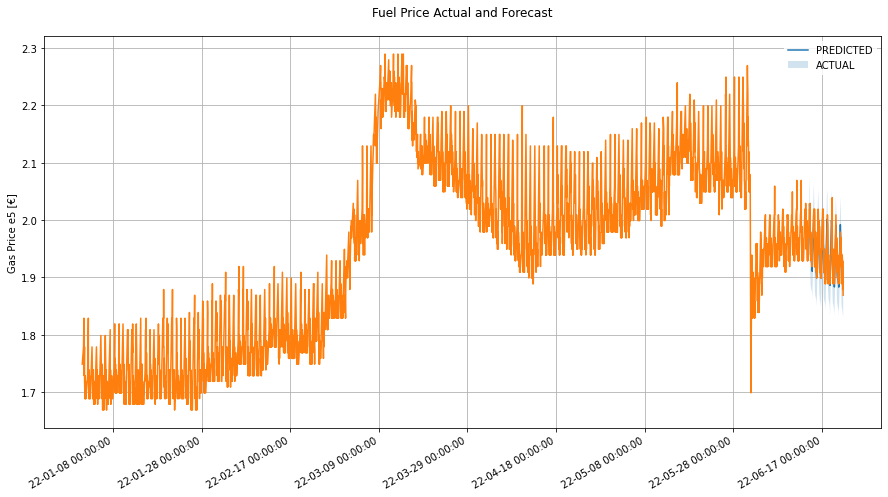

In [236]:
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(pred_data=forecast_018e8f3e.set_index("date"),
                    actual_data=actual_018e8f3e.set_index("date"),
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 8))
#ax.legend(loc="upper left")
#plt.legend(loc="upper left")
#plt.plot(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT'], label='prediction', alpha=.5 )
#plt.plot(to_plot2_gt_pd['date'], to_plot2_gt_pd['e5'], c='green', alpha=0.3, label='ground truth' )
#plt.fill_between(to_plot2_pred_pd['date'], to_plot2_pred_pd['YHAT_LOWER'], to_plot2_pred_pd['YHAT_UPPER'] color='b', alpha=.1, label= 'confidence interval')

ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

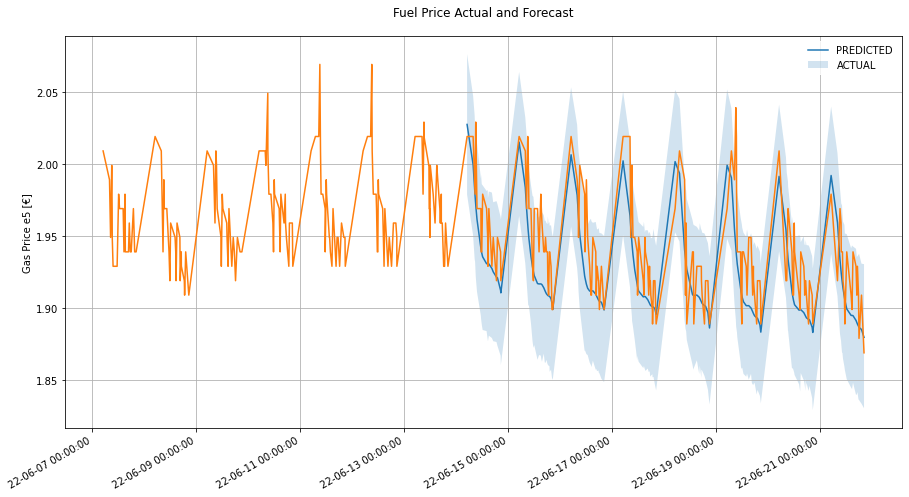

In [239]:
from hana_ml.visualizers.visualizer_base import forecast_line_plot
ax = forecast_line_plot(pred_data=forecast_018e8f3e.set_index("date"),
                    actual_data=actual_018e8f3e.filter('"date" >= \'2022-06-07 00:00:00.000\'').set_index("date"),
                    confidence=("YHAT_LOWER", "YHAT_UPPER"),
                    max_xticklabels=10, figsize=(15, 8))
#ax.legend(loc="upper left")
#plt.legend(loc="upper left")
ax.set_title('Fuel Price Actual and Forecast', pad=20)
plt.ylabel('Gas Price e5 [€]')
plt.show()

In [ ]:
# Evaluate Forecast Accuracy

#print('Number of records', actual_018e8f3e_gt.count())
#print('Number of records', forecast_018e8f3e.count())

#fuelprice_all_hdf.set_index("station_uuid").join(stations_rnkids_hdf.set_index("uuid"))
test_forecast_acc=actual_018e8f3e_gt.set_index("date").join(forecast_018e8f3e.set_index("date"))
test_forecast_acc=test_forecast_acc.select('E5_ACTUAL', 'PREDICTED')
#print(test_forecast_acc.collect())

from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure

res = accuracy_measure(data=test_forecast_acc,
                           evaluation_metric=['mse', 'rmse', 'mpe', 'et',
                                              'mad', 'mase', 'wmape', 'smape',
                                              'mape'])
print(res.collect())

In [432]:
fc2g=fc_result.filter('"GROUP_ID" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\' or "GROUP_ID" = \'938c082c-e2c6-4292-8b2c-cdf83036e555\'')
fc2g=fc2g.select('GROUP_ID', 'date', 'YHAT').rename_columns({'YHAT': 'PREDICTED'})
print(fc2g.head(2).collect())
ac2g=test_gt_rnk_hdf.filter('"station_uuid" = \'018e8f3e-ae2f-40bc-89c1-bc3fe20eb462\' or "station_uuid" = \'938c082c-e2c6-4292-8b2c-cdf83036e555\'')
ac2g=ac2g.sort('date', desc=True).rename_columns({'e5': 'ACTUAL'})
print(ac2g.head(2).collect())

                               GROUP_ID                date  PREDICTED
0  018e8f3e-ae2f-40bc-89c1-bc3fe20eb462 2022-06-14 05:01:07   2.027363
1  018e8f3e-ae2f-40bc-89c1-bc3fe20eb462 2022-06-14 07:48:09   1.999464
                 date                          station_uuid  ACTUAL
0 2022-06-21 21:22:17  938c082c-e2c6-4292-8b2c-cdf83036e555   1.859
1 2022-06-21 20:38:08  938c082c-e2c6-4292-8b2c-cdf83036e555   1.869


In [433]:
testacc2g=ac2g.alias('A').join(fc2g.alias('F'), 
          'A."station_uuid"=F."GROUP_ID" and A."date" = F."date"',
          select=[('station_uuid'), 'ACTUAL', 'PREDICTED'])
print(testacc2g.select_statement)
print(testacc2g.head(10).collect())

SELECT "station_uuid", "ACTUAL", "PREDICTED" FROM (SELECT "date", "station_uuid", "e5" AS "ACTUAL" FROM (SELECT * FROM (SELECT * FROM (SELECT "date", "station_uuid", "e5" FROM (SELECT * FROM "TECHED_USER_999"."TEST_GT_RNK") dt) AS "DT_677" WHERE "station_uuid" = '018e8f3e-ae2f-40bc-89c1-bc3fe20eb462' or "station_uuid" = '938c082c-e2c6-4292-8b2c-cdf83036e555') AS "DT_1446" ORDER BY "date" DESC) AS "DT_1447") AS "A" INNER JOIN (SELECT "GROUP_ID", "date", "YHAT" AS "PREDICTED" FROM (SELECT "GROUP_ID", "date", "YHAT" FROM (SELECT * FROM (SELECT * FROM "#PAL_ADDITIVE_MODEL_PREDICT_FORECAST_RESULT_TBL_5_27500FB4_46E2_11ED_94A4_04D3B07B1629") AS "DT_1374" WHERE "GROUP_ID" = '018e8f3e-ae2f-40bc-89c1-bc3fe20eb462' or "GROUP_ID" = '938c082c-e2c6-4292-8b2c-cdf83036e555') AS "DT_1442") AS "DT_1443") AS "F" ON A."station_uuid"=F."GROUP_ID" and A."date" = F."date"
                           station_uuid  ACTUAL  PREDICTED
0  018e8f3e-ae2f-40bc-89c1-bc3fe20eb462   1.929   1.891462
1  018e8f3e-ae2f-40

In [461]:
conn.create_table(table='FORECAST_ACCURACY',schema='TECHED_USER_999', 
                 table_structure={'station_uuid': 'NVARCHAR(5000)', 'STAT_NAME': 'NVARCHAR(10)', 'STAT_VALUE': 'DOUBLE'})
fc_acc=conn.table('FORECAST_ACCURACY')
#fc_acc.save('FORECAST_ACCURACY', force=True )

In [469]:
#list(set(list(df['column'])))
df=testacc2g.distinct('station_uuid').collect()
stations2=list(set(list(df['station_uuid'])))
print(stations2)

['018e8f3e-ae2f-40bc-89c1-bc3fe20eb462', '938c082c-e2c6-4292-8b2c-cdf83036e555']


In [467]:
stations=['018e8f3e-ae2f-40bc-89c1-bc3fe20eb462', '938c082c-e2c6-4292-8b2c-cdf83036e555']
from hana_ml.algorithms.pal.tsa.accuracy_measure import accuracy_measure
amres = {}
for station in stations2:
    amres[station] = accuracy_measure(data=testacc2g.filter('"station_uuid"=\'{}\''.format(station)).select(['ACTUAL', 'PREDICTED']),
                           evaluation_metric=['mse', 'rmse', 'mpe', 'et',
                                              'mad', 'mase', 'wmape', 'smape',
                                              'mape'])
    #print(amres[station].collect(),  "\n")
    #print(amres[station].select(('\'{}\''.format(station),'station_uuid'), 'STAT_NAME', 'STAT_VALUE').collect(),  "\n")
    amres[station]=amres[station].select(('\'{}\''.format(station),'station_uuid'), 'STAT_NAME', 'STAT_VALUE')
    amres[station].save('FORECAST_ACCURACY', append=True)

In [468]:
#fc_acc=conn.table('FORECAST_ACCURACY')
fc_acc.collect()

,station_uuid,STAT_NAME,STAT_VALUE
0,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,ET,3.479120
1,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,MAD,0.023358
2,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,MAPE,0.011957
3,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,MASE,0.924275
4,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,MPE,0.009584
5,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,MSE,0.000837
6,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,RMSE,0.028923
7,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,SMAPE,0.012052
8,018e8f3e-ae2f-40bc-89c1-bc3fe20eb462,WMAPE,0.012042
9,938c082c-e2c6-4292-8b2c-cdf83036e555,ET,0.689810


### Ex 3.3 Execute forecast on new Data

In [ ]:
# load Data from last week, yesterday, ...
# -- retrain forecast
# -- forecast next 7 days

# Appendix

## still needed for internal prep

 Create CSVs for train, test and ground truth

In [24]:
# in order to predict the last 7 days, we restict our training data to be earlier than 2022-06-14
train_rnk_trunc_hdf  = train_rnk_hdf.filter('"date" < \'2022-06-14 00:00:00.000\'')

In [25]:
# ground truth
test_groundtruth_rnk_hdf  = train_rnk_hdf.filter('"date" >= \'2022-06-14 00:00:00.000\'')

In [26]:
# create test dataset, same as ground truth only target column values set to 0
test_rnk_hdf = test_groundtruth_rnk_hdf.drop(['e5'])
test_rnk_hdf = test_rnk_hdf.add_constant('e5', 0)
test_rnk_hdf = test_rnk_hdf.cast('e5', 'DOUBLE')

In [27]:
test_groundtruth_rnk_hdf.head(3).collect()

,date,station_uuid,e5
0,2022-06-17 09:31:07,e1e4230d-98d0-433b-ad28-bf673862592f,2.019
1,2022-06-18 07:01:08,66f17d7a-2572-4c7a-81a3-91da096629cd,2.029
2,2022-06-18 07:01:08,c0bc562d-d77f-440e-9182-57654145275c,2.009


In [ ]:
# create csv files
test_gt_rnk_pd = test_groundtruth_rnk_hdf.collect()
test_gt_rnk_pd.to_csv('test_groundtruth.csv')

test_rnk_pd = test_rnk_hdf.collect()
test_rnk_pd.to_csv('test_rnk.csv')

train_rnk_pd = train_rnk_trunc_hdf.collect()
train_rnk_pd.to_csv('train_rnk.csv')